In [1]:
%matplotlib inline
from CameraNetwork.image_utils import Normalization
from CameraNetwork.image_utils import FisheyeProxy
import fisheye
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

c:\users\user\documents\code\cameranetwork_git\CameraNetwork\transformation_matrices.py:1899: UserWarning: failed to import module _transformations
  warnings.warn("failed to import module %s" % name)


## ENU convention

In [2]:
X_, Y_ = np.meshgrid(
    np.linspace(-1, 1, 201),
    np.linspace(-1, 1, 201)
)

PHI = np.arctan2(-X_, -Y_)
PSI = np.pi/2 * np.sqrt(X_**2 + Y_**2)

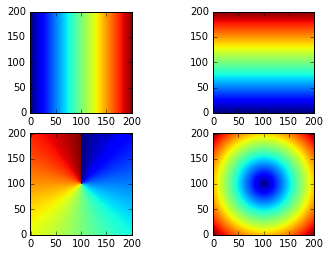

In [3]:
_, ax = plt.subplots(ncols=2, nrows=2)
ax[0, 0].imshow(X_, origin='lower')
ax[0, 1].imshow(Y_, origin='lower')
ax[1, 0].imshow(PHI, origin='lower')
ax[1, 1].imshow(PSI, origin='lower')

## Captured Data

### Raw data

In the raw data the coordinates depend on the (random) orientation of the sensor inside the camera.

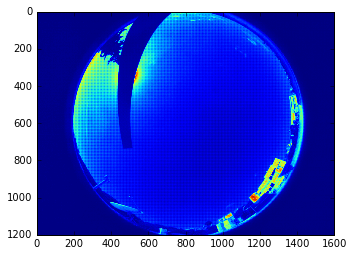

In [19]:
img = sio.loadmat('data/1476876720.0_2016_10_19_11_32_00_2.mat')['img_array']
plt.imshow(img)

### After normalization

After normalization the image horizontal (second, X) axis increases to the east, the vertical axis (first, Y) increases to the north

In [20]:
fe = fisheye.load_model('data/.calibration_data.dat', calib_img_shape=(1200, 1600))
R = np.load('data/.extrinsic_data.npy')
nm = Normalization(resolution=301, fisheye_model=FisheyeProxy(fe), Rot=R)

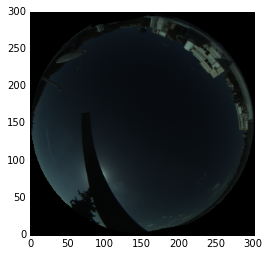

In [21]:
plt.imshow(nm.normalize(img), origin="lower")

## PyQtGraph Conventions

From the documentation:

By default, the positive y-axis points upward on the screen. Use invertY(True) to reverse the y-axis.

Note:
This is the opposite from matplotlib.

In [16]:
%run ImageView.py

RuntimeError: wrapped C/C++ object of type ViewBox has been deleted

## SHDOM Conventions

From the documentaion:

mu = cosine of the solar zenith angle (this represents the direction of travel of the solar beam, so is forced to be negative although it can be specified positive).

az = solar beam azimuthal angle; specified in degrees but immediately converted to radians for use in code. 0 is beam going in positive X direction, 90 is positive Y.

It is important to note that in SHDOM the angles are measured in the directions of the photons.